In [59]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from uuid import uuid4

import boto3
import matplotlib.pyplot as plt
import polars as pl
import sagemaker
from hydra import compose, core, initialize
from omegaconf import OmegaConf
from sagemaker.estimator import Estimator
from sagemaker.model import Model
from sagemaker.transformer import Transformer
from scipy.stats import gaussian_kde

sys.path.append(os.path.abspath(os.path.join("..")))
from src.model_utils import get_db_url
from src.plot_utils import StudyVisualizer

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base="1.2", config_path="../src/config", job_name="classification")
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

config["xgboost"]

{'base_job_name': 'xgboost-training',
 'model_name': 'xgboost-model',
 'study_name': 'xgboost-hpo',
 'instance_type': 'ml.c5.9xlarge',
 'instance_count': 1}

## S3

In [31]:
s3_train_prefix = f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/cluster/'

train_channel = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=s3_train_prefix,
        distribution="FullyReplicated",
        content_type="application/x-parquet",
        s3_data_type="S3Prefix",
        input_mode="File",
    )
}

train_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f7fb6b67020>}

## SageMaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sm_client = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

## Database Setup

In [5]:
cf_client = boto3.client("cloudformation")
outputs = cf_client.describe_stacks(StackName=config["stack_name"])["Stacks"][0][
    "Outputs"
]

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out["OutputValue"] for out in outputs if out["OutputKey"] == "ClusterEndpoint"][
    0
].split(":")[0]
db_name = [out["OutputValue"] for out in outputs if out["OutputKey"] == "DatabaseName"][
    0
]
secret_name = (
    [out["OutputValue"] for out in outputs if out["OutputKey"] == "DBSecretArn"][0]
    .split(":")[-1]
    .split("-")[0]
)

subnets = [
    out["OutputValue"] for out in outputs if out["OutputKey"] == "PrivateSubnets"
][0].split(",")
security_group_ids = [
    out["OutputValue"]
    for out in outputs
    if out["OutputKey"] == "SageMakerSecurityGroup"
][0].split(",")

db_url = get_db_url(
    host=host,
    db_name=db_name,
    db_secret=secret_name,
    region_name=sagemaker_session._region_name,
)

## Training Job

### Docker Image

In [ ]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh train-latest train {config['ecr_repository']}

Construct the training job image uri:

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = "\n".join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str["imageIds"]:
    if "imageTag" in ecr_meta_data_dict and ecr_meta_data_dict["imageTag"].startswith(
        "train"
    ):
        train_image_tag = ecr_meta_data_dict["imageTag"]

train_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{train_image_tag}'

### Test Locally

In [16]:
!sudo rm -rf /tmp/tmp*

In [ ]:
test_study_name = "test_study"

test_estimator = Estimator(
    # Sagemaker
    image_uri=train_image_uri,
    role=role,
    instance_type="local",
    instance_count=config["xgboost"]["instance_count"],
    model_dir=config["model_dir"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    volume_size=config["volume_size"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": test_study_name,
        "db_secret": secret_name,
        "region_name": sagemaker_session._region_name,
        "n_trials": 2,
        "test_mode": 1,
    },
)

test_estimator.fit(inputs=train_channel, wait=True)

Delete test study database:

In [22]:
optuna.study.delete_study(study_name=test_study_name, storage=db_url)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


### Hyperparameter Optimization

In [8]:
estimator = Estimator(
    # Sagemaker
    image_uri=train_image_uri,
    role=role,
    instance_type=config["xgboost"]["instance_type"],
    instance_count=config["xgboost"]["instance_count"],
    model_dir=config["model_dir"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    volume_size=config["volume_size"],
    max_run=config["max_run"],
    base_job_name=config["xgboost"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Spot training
    max_wait=config["max_wait"],
    max_retry_attempts=config["max_retry_attempts"],
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "xgboost"),
    use_spot_instances=config["use_spot_instances"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": config["xgboost"]["study_name"],
        "db_secret": secret_name,
        "region_name": sagemaker_session._region_name,
        "n_trials": 100,
        "test_mode": 0,
    },
)

estimator

In [ ]:
max_parallel_jobs = 3

for i in range(max_parallel_jobs - 1):
    estimator.fit(inputs=train_channel, wait=False)
estimator.fit(inputs=train_channel)

### Visualize HPO Results

In [8]:
study = optuna.study.load_study(
    study_name=config["xgboost"]["study_name"], storage=db_url
)

hpo_visualizer = StudyVisualizer(study=study)
hpo_visualizer

#### Optimization History

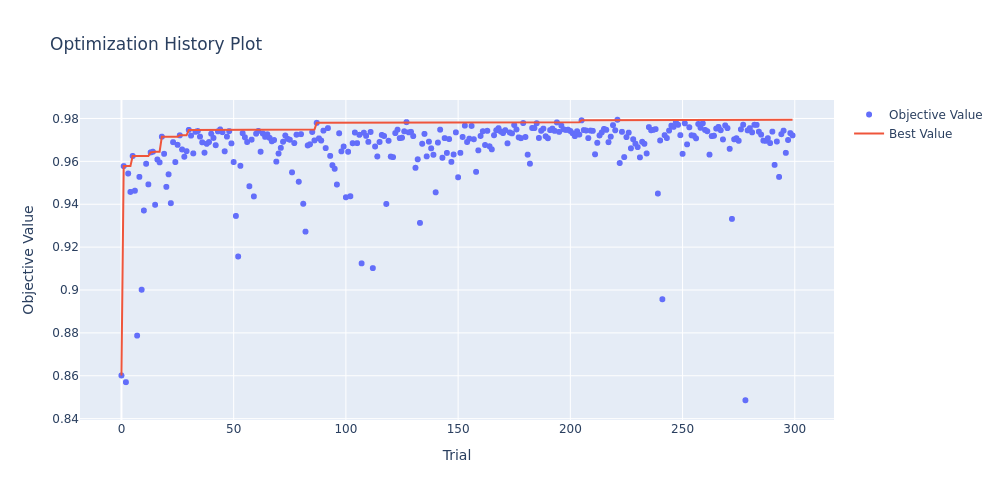

In [9]:
hpo_visualizer.plot_optimization_history(figsize=(1000, 500))

#### Paralell Coordinates

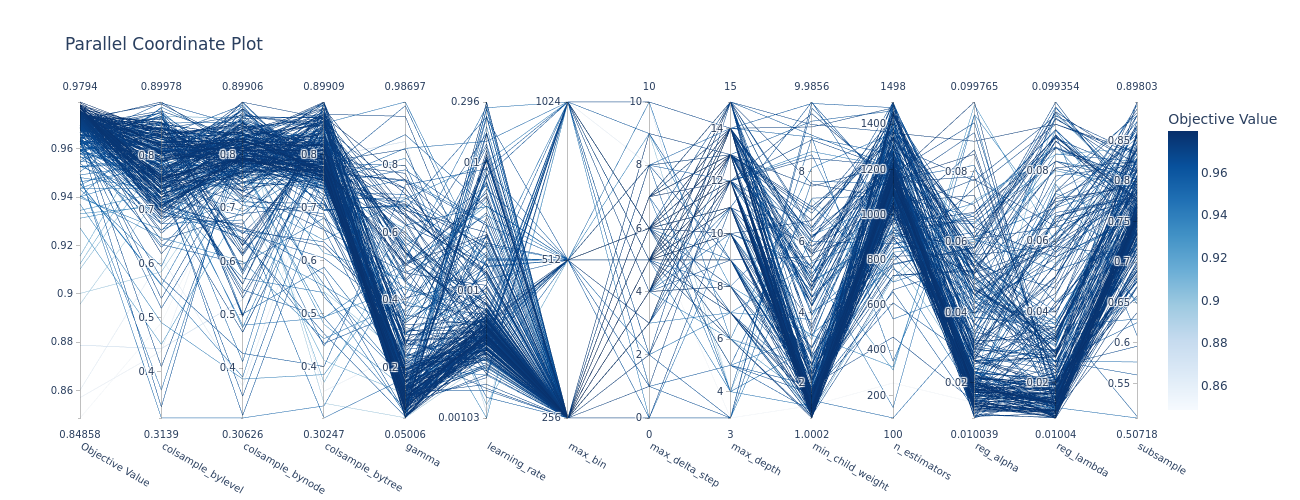

In [11]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500),
    params=[
        "n_estimators",
        "max_depth",
        "learning_rate",
        "gamma",
        "max_delta_step",
        "min_child_weight",
        "subsample",
        "colsample_bytree",
        "colsample_bylevel",
        "colsample_bynode",
        "reg_alpha",
        "reg_lambda",
        "max_bin",
    ],
)

#### Hyperparameter Importance

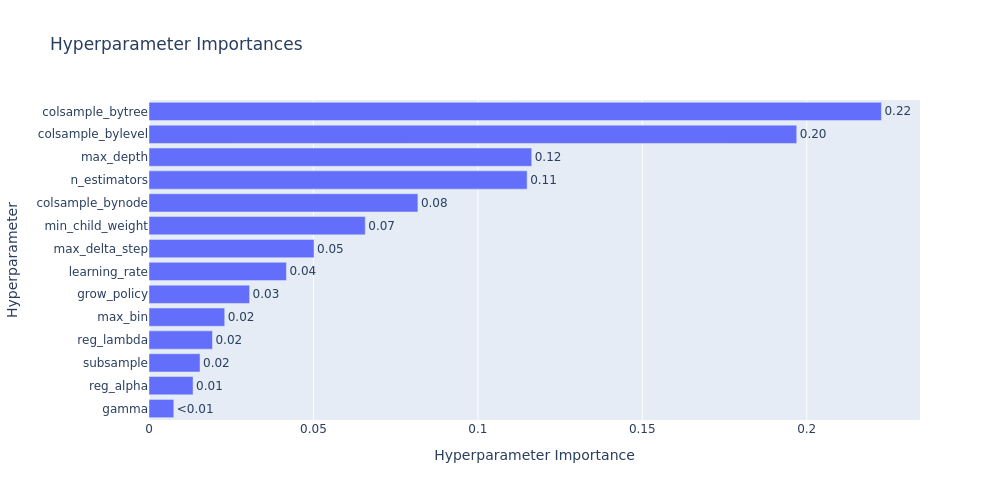

In [12]:
hpo_visualizer.plot_param_importances(figsize=(1000, 500))

## SageMake Model

In [9]:
best_model_s3_path = sm_client.describe_training_job(
    TrainingJobName=study.best_trial.user_attrs["job_name"]
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path}")

Best model artifacts persisted at s3://yang-ml-sagemaker/tenant-experience/models/xgboost-training-2024-11-12-22-59-05-860/output/model.tar.gz


### Docker Image

In [ ]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh serve-latest serve {config['ecr_repository']}

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = "\n".join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str["imageIds"]:
    if "imageTag" in ecr_meta_data_dict and ecr_meta_data_dict["imageTag"].startswith(
        "serve"
    ):
        train_image_tag = ecr_meta_data_dict["imageTag"]

serve_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{train_image_tag}'

### Model Entity

Create model entity:

In [63]:
model = Model(
    image_uri=serve_image_uri,
    model_data=best_model_s3_path,
    role=role,
    name=config["model_name_prefix"] + f"-v{uuid4().hex[:6]}",
    sagemaker_session=sagemaker_session,
)

model.create(
    instance_type=None, tags=[{"Key": "project", "Value": config["stack_name"]}]
)

INFO:sagemaker:Creating model with name: tenant-experience-xgboost-v44bcb1


## Batch Transform

Testing the batch transform job:

In [22]:
transformer = Transformer(
    model_name=model.name,
    instance_count=config["transformer_instance_count"],
    instance_type=config["transformer_instance_type"],
    strategy=config["transformer_strategy"],
    output_path=config["transformer_output_path"],
    accept="text/csv",
    max_concurrent_transforms=config["transformer_max_concurrent_transforms"],
    max_payload=config["transformer_max_payload"],
    base_transform_job_name=config["transformer_base_transform_job_name"],
    sagemaker_session=sagemaker_session,
)

In [ ]:
s3_test_prefix = f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test/'

transformer.transform(
    data=s3_test_prefix,
    data_type="S3Prefix",
    content_type="application/x-parquet",
    model_client_config={"InvocationsTimeoutInSeconds": 60, "InvocationsMaxRetries": 2},
    wait=True,
)

Check predictions saved to s3:

In [54]:
predictions = pl.scan_csv(config["transformer_output_path"] + "/*.out").collect()

predictions

predicted_class,predicted_probability
i64,f64
0,0.978916
1,0.99841
0,1.0
0,1.0
0,1.0
…,…
1,0.998889
1,0.999488
0,0.787576


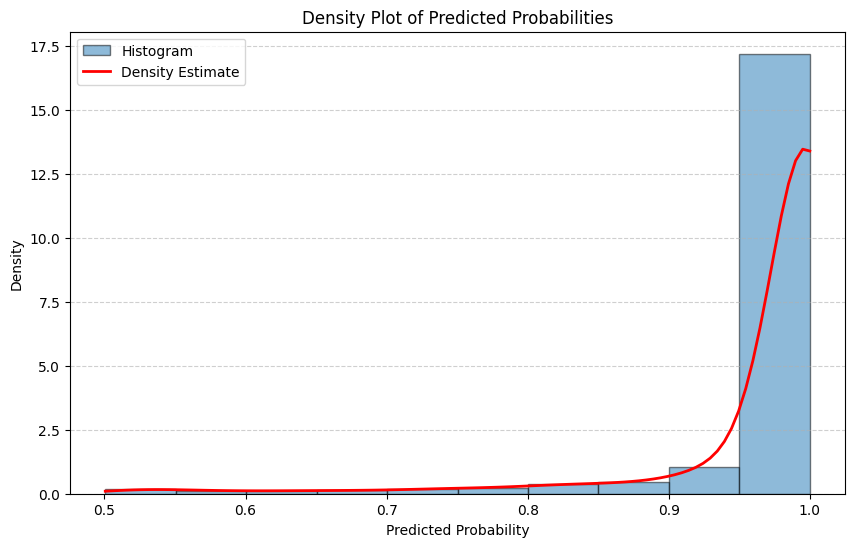

In [60]:
plt.figure(figsize=(10, 6))
plt.hist(
    predictions["predicted_probability"],
    bins=10,
    density=True,
    alpha=0.5,
    label="Histogram",
    edgecolor="black",
)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Density Plot of Predicted Probabilities")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Calculate the KDE
kde = gaussian_kde(predictions["predicted_probability"], bw_method=0.3)
x_vals = np.linspace(
    min(predictions["predicted_probability"]),
    max(predictions["predicted_probability"]),
    100,
)
y_vals = kde(x_vals)
plt.plot(x_vals, y_vals, color="red", lw=2, label="Density Estimate")
plt.legend()
plt.show()

## Clean-up

In [61]:
sm_client.close()

In [62]:
model.delete_model()

INFO:sagemaker:Deleting model with name: tenant-experience-xgboost-v2afb07
